In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import joblib
import os
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import NMF, LatentDirichletAllocation

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

import sklearn.metrics as metrics

import warnings

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))


mpl.rcParams["figure.figsize"] = (15, 10)
warnings.filterwarnings('ignore')

In [4]:
%time df = pd.read_csv('cleanDfStackOverflow.csv', index_col=0, converters={'Corpus': literal_eval, 'Tags': literal_eval})


CPU times: user 1.85 s, sys: 86.1 ms, total: 1.94 s
Wall time: 2.6 s


# Preprocessing

In [58]:
X = df['Corpus']
y = df['Tags']

In [6]:
def preprocessing(feature_extraction, X, y):
    # Vectorize X
    vectorizer = feature_extraction(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
    vectorized_data = vectorizer.fit_transform(X)
    feature_names = vectorizer.get_feature_names()
    print("Shape of X: {}".format(vectorized_data.shape))
    
    # Multi label binarize y
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(y)
    y_binarized = multilabel_binarizer.transform(y)
    print("Shape of y: {}".format(y_binarized.shape))
    
    # Create train and test split (30%) => NFM
    X_train, X_test, y_train, y_test = train_test_split(vectorized_data, y_binarized, test_size=0.3, random_state=8)
    print("X_train shape : {}".format(X_train.shape))
    print("X_test shape : {}".format(X_test.shape))
    print("y_train shape : {}".format(y_train.shape))
    print("y_test shape : {}".format(y_test.shape))
    
    return [X_train, X_test, y_train, y_test, vectorized_data, feature_names]


# Unsupervised Models

## LDA = Latent Dirichlet Allocation

LDA can only use raw term counts for LDA because it is a probabilistic graphical model

In [5]:
X_train_tf, X_test_tf, y_train_ft, y_test_tf, tf, tf_feature_names = preprocessing(CountVectorizer, X, y)

Shape of X: (11244, 1023)
Shape of y: (11244, 50)
X_train shape : (7870, 1023)
X_test shape : (3374, 1023)
y_train shape : (7870, 50)
y_test shape : (3374, 50)


In [6]:
%time lda = LatentDirichletAllocation(n_components=20, max_iter=5, learning_method='online', learning_offset=50, random_state=0).fit(tf)


CPU times: user 20.7 s, sys: 83.4 ms, total: 20.8 s
Wall time: 19.7 s


In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [8]:
print('LDA :')
display_topics(lda, tf_feature_names, no_top_words)

LDA :
Topic 0:
angular difference use component event bind element select vs query
Topic 1:
use question code one like would make understand example time
Topic 2:
array object get git like value use want date pandas
Topic 3:
version code studio visual project open work php update latest
Topic 4:
string request api kotlin use loop get response post deprecate
Topic 5:
java use image set text like try want add code
Topic 6:
python run use command install line environment windows instal try
Topic 7:
app xcode component use firebase flutter google ios user router
Topic 8:
remove access get server try log use create user work
Topic 9:
page react button state load render click content form html
Topic 10:
warn method app field upload feature use context static notification
Topic 11:
type class typescript property use object properties like create interface
Topic 12:
test view container list name run pod unit kubernetes jest
Topic 13:
data model save tensorflow network widget train way layer ra

## NMF = Non-Negative Matrix Factorization

In [57]:
X_train, X_test, y_train, y_test, tfidf, tfidf_feature_names = preprocessing(TfidfVectorizer, X, y)

Shape of X: (11244, 1023)
Shape of y: (11244, 50)
X_train shape : (7870, 1023)
X_test shape : (3374, 1023)
y_train shape : (7870, 50)
y_test shape : (3374, 50)


In [10]:
%time nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

CPU times: user 2.13 s, sys: 36.3 ms, total: 2.17 s
Wall time: 1.17 s


In [11]:
print("NMF :")
display_topics(nmf, tfidf_feature_names, no_top_words)

NMF :
Topic 0:
use function like work call code way would want make
Topic 1:
android gradle studio app build project version google com support
Topic 2:
docker container compose run command containers dockerfile host windows start
Topic 3:
angular component cli ts module material ng template form html
Topic 4:
error get try follow message module fail run give code
Topic 5:
net core asp project framework application web mvc json microsoft
Topic 6:
file import project folder json directory js open webpack upload
Topic 7:
react component native render prop components router hook state app
Topic 8:
type typescript property string return ts hint interface define class
Topic 9:
class kotlin java method constructor convert static lang jdk spring
Topic 10:
package install command npm run version instal node project json
Topic 11:
visual studio code vs line open project editor terminal vscode
Topic 12:
test jest unit mock run fail write class case pass
Topic 13:
object array json key javascript

# Supervised Models

In [12]:
def metrics_score(model, df, y_true, y_pred):
    if(df is not None):
        dataframe = df
    else:
        dataframe = pd.DataFrame(index=["Accuracy", "Recall", "Precision"], columns=[model])
        
    scores = []
    
    scores.append(metrics.accuracy_score(y_true, y_pred))
    scores.append(metrics.recall_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    
    dataframe[model] = scores
    
    return dataframe

In [13]:
def multiLabelModelClassifierPredictions(estimator, params, name, metrics_compare_df):    
    # GridSearchCV
    multi_label_cv = GridSearchCV(estimator=estimator,
                              param_grid=params,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
    
    # fit the model
    %time multi_label_cv.fit(X_train, y_train)
    
    # Best params
    logit_cv_results = pd.DataFrame.from_dict(multi_label_cv.cv_results_)
    print("-"*50)
    printmd(f'Best params for : **{name}**')
    print("-" * 50)
    logit_best_params = multi_label_cv.best_params_
    print(logit_best_params)
    
    # Results with best params
    logit_cv_results[logit_cv_results["params"] == logit_best_params]
    
    # Predict
    y_test_predicted_labels_tfidf = multi_label_cv.predict(X_test)

    # Inverse transform
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(y)
    y_test_pred_inversed = multilabel_binarizer.inverse_transform(y_test_predicted_labels_tfidf)
    y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

    print("-"*50)
    print("Print 10 first predicted Tags vs true Tags")
    print("-" * 50)
    print("Predicted:", y_test_pred_inversed[0:10])
    print("True:", y_test_inversed[0:10])
    
    # Metrics compare
    df_metrics_compare = metrics_score(name, df=metrics_compare_df, y_true = y_test, y_pred = y_test_predicted_labels_tfidf)
    return df_metrics_compare


## Logistic Regression

In [14]:
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear", 'sag']}

df_metrics_compare = multiLabelModelClassifierPredictions(
    OneVsRestClassifier(LogisticRegression()),
    param_logit,
    'Logistic Regression',
    None
)

CPU times: user 5.8 s, sys: 149 ms, total: 5.94 s
Wall time: 2min 5s
--------------------------------------------------


Best params for : **Logistic Regression**

--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('node.js',), ('python',), (), ('angular',), ('c#',), (), (), (), ('css', 'html'), ()]
True: [('javascript',), ('python',), ('javascript',), ('angular',), ('.net', '.net-core', 'c#'), ('angular',), ('java',), ('dart', 'flutter'), ('css', 'html'), ('asp.net-core', 'c#')]


In [15]:
df_metrics_compare

,Logistic Regression
Accuracy,0.371962
Recall,0.620716
Precision,0.727564


## XGBoost

In [17]:
params_XGBoost = {
    'estimator__max_depth': range (2, 10, 1),
    'estimator__n_estimators': range(60, 220, 40),
    'estimator__learning_rate': [0.1, 0.01, 0.05]
}

df_metrics_compare = multiLabelModelClassifierPredictions(
    OneVsRestClassifier(xgb.XGBClassifier(
        objective= 'binary:logistic',
        nthread=4,
        seed=42
    )),
    {},
    'XGBoost Classifier',
    df_metrics_compare
)

[04:30:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[04:31:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[04:32:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Best params for : **XGBoost Classifier**

--------------------------------------------------
{}
--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('node.js', 'reactjs'), ('python',), (), ('angular',), ('c#',), (), ('java',), (), ('css', 'html'), ()]
True: [('javascript',), ('python',), ('javascript',), ('angular',), ('.net', '.net-core', 'c#'), ('angular',), ('java',), ('dart', 'flutter'), ('css', 'html'), ('asp.net-core', 'c#')]


In [18]:
df_metrics_compare

,Logistic Regression,XGBoost Classifier
Accuracy,0.371962,0.415827
Recall,0.620716,0.633403
Precision,0.727564,0.797657


## KNeighborsClassifier

In [19]:
param_knn = {"estimator__n_neighbors": list(range(1, 11))}

df_metrics_compare = multiLabelModelClassifierPredictions(
    OneVsRestClassifier(KNeighborsClassifier()),
    param_knn,
    'K Neighbors Classifier',
    df_metrics_compare
)

CPU times: user 583 ms, sys: 177 ms, total: 761 ms
Wall time: 37min 23s
--------------------------------------------------


Best params for : **K Neighbors Classifier**

--------------------------------------------------
{'estimator__n_neighbors': 5}
--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('node.js',), (), ('angular',), (), (), (), ('pandas', 'python'), ('css',), ()]
True: [('javascript',), ('python',), ('javascript',), ('angular',), ('.net', '.net-core', 'c#'), ('angular',), ('java',), ('dart', 'flutter'), ('css', 'html'), ('asp.net-core', 'c#')]


In [20]:
df_metrics_compare

,Logistic Regression,XGBoost Classifier,K Neighbors Classifier
Accuracy,0.371962,0.415827,0.283640
Recall,0.620716,0.633403,0.426434
Precision,0.727564,0.797657,0.732024


## Random Forest Classifier

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# Maximum number of levels in tree
max_depth = list(range(10, 15))
max_depth.append(None)

param_rfc = {'estimator__n_estimators': n_estimators,
               'estimator__max_depth': max_depth}

df_metrics_compare = multiLabelModelClassifierPredictions(
    OneVsRestClassifier(RandomForestClassifier()),
    {},
    'Random Forest Classifier',
    df_metrics_compare
)

CPU times: user 1min 25s, sys: 1.01 s, total: 1min 26s
Wall time: 4min 28s
--------------------------------------------------


Best params for : **Random Forest Classifier**

--------------------------------------------------
{}
--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('node.js',), ('python',), (), ('angular',), (), (), (), (), (), ()]
True: [('javascript',), ('python',), ('javascript',), ('angular',), ('.net', '.net-core', 'c#'), ('angular',), ('java',), ('dart', 'flutter'), ('css', 'html'), ('asp.net-core', 'c#')]


In [22]:
df_metrics_compare

,Logistic Regression,XGBoost Classifier,K Neighbors Classifier,Random Forest Classifier
Accuracy,0.371962,0.415827,0.283640,0.370480
Recall,0.620716,0.633403,0.426434,0.498959
Precision,0.727564,0.797657,0.732024,0.773863


# Export fitted model and preprocessor

#### TF-idf Vectorizer

In [59]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
tfidf_vectorizer.fit(X)

TfidfVectorizer(lowercase=False, max_df=0.6, min_df=0.005,
                preprocessor=<built-in method join of str object at 0x7fcc25570f30>)

#### Multi label binarizer 

In [60]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)

MultiLabelBinarizer()

#### Final model

In [10]:
final_model = OneVsRestClassifier(xgb.XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42 ))
%time final_model.fit(X_train, y_train)

[23:33:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[23:34:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[23:35:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            nthread=4, num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                           

#### Export

In [ ]:
dirname = os.path.join(os.getcwd(), 'exported_models/')

In [ ]:
print(dirname)

In [ ]:
joblib.dump(tfidf_vectorizer, dirname+'tfidf_vectorizer.pkl')

In [ ]:
joblib.dump(final_model, dirname+'xgboost_classifier_model.pkl')
joblib.dump(multilabel_binarizer, dirname+'multilabel_binarizer.pkl')

# Tests

In [23]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arminarnautovic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arminarnautovic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def preprocess_text(text):
    # remove code tag
    soup = BeautifulSoup(text,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    # remove html tag
    txt_without_html_tag = soup.get_text()
    # only letters
    letters_only = re.sub("[^a-zA-Z]", " ", txt_without_html_tag)
    #lowercase
    lowercase = letters_only.lower()
    # Create an instance of RegexpTokenizer for alphanumeric tokens
    tokeniser = RegexpTokenizer(r'\w+')
    # Tokenise string
    tokens = tokeniser.tokenize(lowercase)
    # Create an instance of WordNetLemmatizer
    lemmatiser = WordNetLemmatizer()
    # lemmatise tokens
    lemmas = [lemmatiser.lemmatize(token, pos='v') for token in tokens]
    # Remove stops words
    keywords = [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords

In [25]:
title_test = "How to Modify CSS Module Style via Javascript"
body_test = "I'm fairly new to javascript and react, but I'm diving in and creating my first react app. I'm tying to modify the amount of 'gridTemplateRows' that display on my screen via a variable and modify it with a new numbers based on the results from the list (I've hard coded this as a 6 right now), however I'm using CSS Modules and i can't seem to get the grid to change its row count and display properly."

In [26]:
cleaned_title = preprocess_text(title_test)
cleaned_body = preprocess_text(body_test)

In [27]:
corpus_test = cleaned_title + cleaned_body

In [28]:
corpus_test

['modify',
 'css',
 'module',
 'style',
 'via',
 'javascript',
 'fairly',
 'new',
 'javascript',
 'react',
 'dive',
 'create',
 'first',
 'react',
 'app',
 'tie',
 'modify',
 'amount',
 'gridtemplaterows',
 'display',
 'screen',
 'via',
 'variable',
 'modify',
 'new',
 'number',
 'base',
 'result',
 'list',
 'hard',
 'cod',
 'right',
 'however',
 'use',
 'css',
 'modules',
 'seem',
 'get',
 'grid',
 'change',
 'row',
 'count',
 'display',
 'properly']

In [29]:
X_to_test = [corpus_test]

In [30]:
X_to_test

[['modify',
  'css',
  'module',
  'style',
  'via',
  'javascript',
  'fairly',
  'new',
  'javascript',
  'react',
  'dive',
  'create',
  'first',
  'react',
  'app',
  'tie',
  'modify',
  'amount',
  'gridtemplaterows',
  'display',
  'screen',
  'via',
  'variable',
  'modify',
  'new',
  'number',
  'base',
  'result',
  'list',
  'hard',
  'cod',
  'right',
  'however',
  'use',
  'css',
  'modules',
  'seem',
  'get',
  'grid',
  'change',
  'row',
  'count',
  'display',
  'properly']]

In [35]:
# Preprocessing
X_final_test = tfidf_vectorizer.transform(X_to_test)

In [36]:
df_test = pd.DataFrame.sparse.from_spmatrix(X_final_test)
col_map = {v:k for k, v in tfidf_vectorizer.vocabulary_.items()}
for col in df_test.columns:
    df_test.rename(columns={col: col_map[col]}, inplace=True)
df_test

,able,accept,access,accomplish,accord,account,achieve,across,action,activity,...,would,wrap,write,wrong,www,xcode,xml,yes,yet,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Prediction
predicted_labels_test = final_model.predict(X_final_test)

In [38]:
# Inverse transform
pred_inversed_test = multilabel_binarizer.inverse_transform(predicted_labels_test)

In [39]:
# Print predicted tags
pred_inversed_test

[('javascript', 'reactjs')]

## t-SNE

In [29]:
from yellowbrick.text import TSNEVisualizer

In [28]:
tfidf = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

tuple_vectors = tfidf.fit_transform(X)

In [45]:
y_tsne = multilabel_binarizer.classes_

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


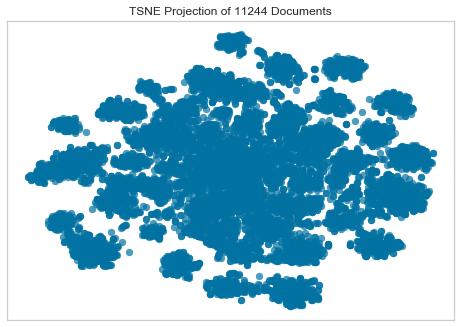

In [65]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tuple_vectors)
tsne.show()

In [75]:
y_okok = [i[0] for i in y]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

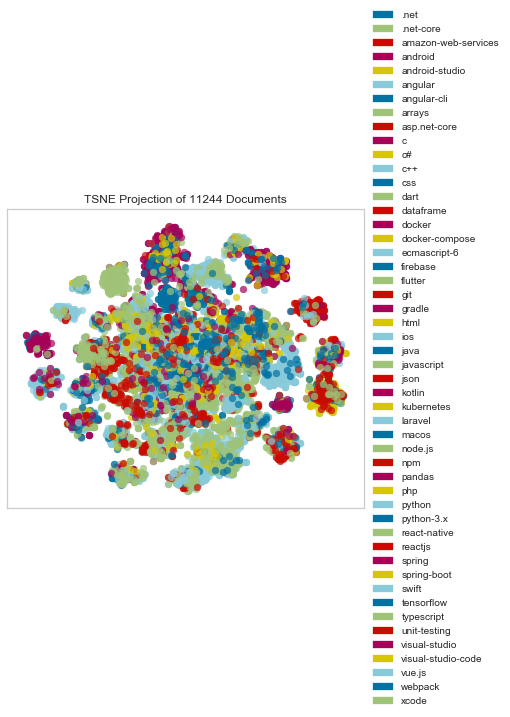

In [77]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tuple_vectors, y_okok)
tsne.show()